In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.9.dev2218
Numpy version: 1.21.5
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 127aef33d48f499b0b07b1aed0543bab1b913765
MONAI __file__: D:\Software\Anaconda3\envs\dl\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#in

In [2]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [3]:
data_dir = "./data/"
split_JSON = "dataset_0.json"
datasets = data_dir + split_JSON


datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset: 100%|██████████| 6/6 [00:17<00:00,  2.83s/it]


In [9]:
train_ds[0][0]['image'].shape

torch.Size([1, 96, 96, 96])

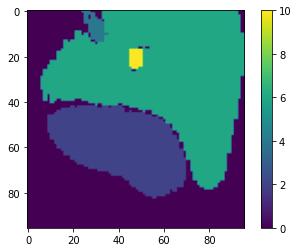

In [14]:
plt.imshow(train_ds[0][0]['label'][0, 43])
plt.colorbar()

In [24]:
for i in train_loader:
    print(len(i))
    break

8
